# Inventory Monitoring at Distribution Centers

This notebook trains uses the “Amazon Bin Image Dataset” dataset to perform transfer learning on a pretrained model to predict the number of items inside images. The model is also deployed to an end point. A example request with Jpg and Json object is done at the end.

In [54]:
# TODO: Import any packages that you might need
import os
import io
import json
import boto3
import sagemaker
import IPython
import requests
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sagemaker.s3 import s3_path_join
from sagemaker.pytorch import PyTorch, PyTorchModel
from sagemaker.predictor import Predictor
from sagemaker.analytics import HyperparameterTuningJobAnalytics
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)
from sagemaker.debugger import (
    Rule,
    ProfilerRule,
    rule_configs,
    DebuggerHookConfig,
    ProfilerConfig,
    FrameworkProfile,
    CollectionConfig
)
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys
from PIL import Image

In [5]:
session = sagemaker.Session()

bucket = "mlnd-capstone-project"

region = session.boto_session.region_name

try:
    role = sagemaker.get_execution_role()
except ValueError:
    role = os.environ["AWS_ROLE_DEFAULT"]

In [29]:
report_image_dir = os.path.join("report", "images")
if not os.path.exists(report_image_dir):
    os.makedirs(report_image_dir) 

## Data Preparation
Run the cell below to download the data.

The cell below creates three folders called `train`, `valid` and `test`, downloads data and arranges it in subfolders. Each of these subfolders contain images where the number of objects is equal to the name of the folder. For instance, all images in folder `1` has images with 1 object in them. If you feel like the number of samples are not enough, you can always download more data (instructions for that can be found [here](https://registry.opendata.aws/amazon-bin-imagery/)). However, we are not acessing you on the accuracy of your final trained model, but how you create your machine learning engineering pipeline.

In [6]:
data_sets = ["train", "valid", "test"]

In [8]:
def download_and_arrange_data():
    s3_client = boto3.client('s3')

    train_size = 0.7
    val_size = 0.2
    file_data_sets = {s:{} for s in data_sets}
    with open('file_list.json', 'r') as f:
        d=json.load(f)

    for k, v in d.items():
        print(f"Downloading Images with {k} objects")
        file_data_sets[data_sets[0]][k], file_data_sets[data_sets[1]][k] = train_test_split(v, test_size=1-train_size, random_state=42)
        file_data_sets[data_sets[1]][k], file_data_sets[data_sets[2]][k] = train_test_split(file_data_sets[data_sets[1]][k], test_size=1-val_size/(1-train_size), random_state=42)
        for subset in data_sets:
            print(f"Subset: {subset}")            
            directory=os.path.join("data", subset, k)
            if not os.path.exists(directory):
                os.makedirs(directory)        
            for file_path in tqdm(file_data_sets[subset][k]):            
                file_name=os.path.basename(file_path).split('.')[0]+'.jpg'
                file = os.path.join(directory, file_name)
                if not os.path.exists(file):
                    s3_client.download_file('aft-vbi-pds', s3_path_join('bin-images', file_name), file)
    return file_data_sets

files = download_and_arrange_data()

Subset: train


100%|██████████| 859/859 [00:00<00:00, 252924.33it/s]


Subset: valid


100%|██████████| 245/245 [00:00<00:00, 254357.54it/s]


Subset: test


100%|██████████| 124/124 [00:00<00:00, 212978.58it/s]


Subset: train


100%|██████████| 1609/1609 [00:00<00:00, 293329.64it/s]


Subset: valid


100%|██████████| 459/459 [00:00<00:00, 230120.19it/s]


Subset: test


100%|██████████| 231/231 [00:00<00:00, 189494.27it/s]


Subset: train


100%|██████████| 1866/1866 [00:00<00:00, 281602.25it/s]


Subset: valid


100%|██████████| 533/533 [00:00<00:00, 249727.89it/s]


Subset: test


100%|██████████| 267/267 [00:00<00:00, 239443.91it/s]


Subset: train


100%|██████████| 1661/1661 [00:00<00:00, 272148.87it/s]


Subset: valid


100%|██████████| 474/474 [00:00<00:00, 237811.02it/s]


Subset: test


100%|██████████| 238/238 [00:00<00:00, 250061.21it/s]


Subset: train


100%|██████████| 1312/1312 [00:00<00:00, 284624.33it/s]


Subset: valid


100%|██████████| 375/375 [00:00<00:00, 265104.33it/s]


Subset: test


100%|██████████| 188/188 [00:00<00:00, 244429.37it/s]


## Dataset
The dataset used is the Amazon Bin Image Dataset. You can find more information about the data [here](https://registry.opendata.aws/amazon-bin-imagery/).

### Classes

In [9]:
classes = list(list(files.values())[0].keys())
print(f"The classes are: {classes}")

The classes are: ['1', '2', '3', '4', '5']


### Distribution

The distribution of the images is like follows:


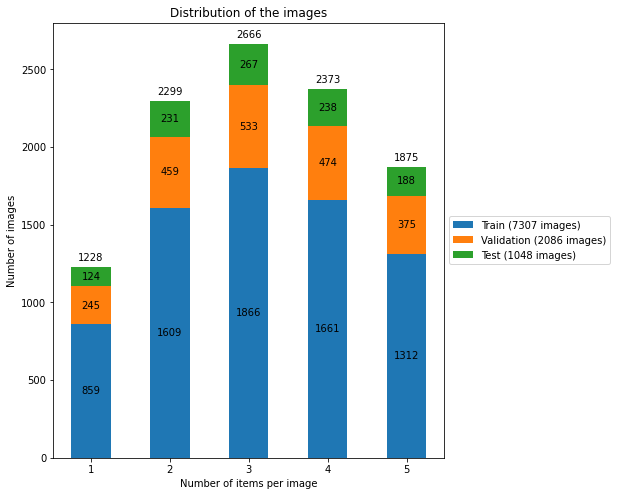

In [6]:
def plot_distribution(directory):
    width = 0.5
    x = np.arange(len(classes))
    
    fig, ax = plt.subplots(figsize=(7,8))
        
    num_data_sets = {k: [len(fv) for _, fv in v.items()] for k, v in files.items()}
    sum_data_sets = {k: sum(v) for k, v in num_data_sets.items()}
    
    train_bar = ax.bar(x, num_data_sets["train"], width, label="Train ({} images)".format(sum_data_sets["train"]))
    valid_bar = ax.bar(x, num_data_sets["valid"], width, bottom=num_data_sets["train"], label="Validation ({} images)".format(sum_data_sets["valid"]))
    test_bar = ax.bar(x, num_data_sets["test"], width, bottom=np.add(num_data_sets["train"], num_data_sets["valid"]), label="Test ({} images)".format(sum_data_sets["test"]))
    
    ax.set_ylabel('Number of images')
    ax.set_xlabel('Number of items per image')
    ax.set_title('Distribution of the images')
    ax.set_xticks(x, classes)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    ax.bar_label(train_bar, label_type='center')
    ax.bar_label(valid_bar, label_type='center')
    ax.bar_label(test_bar, label_type='center')
    ax.bar_label(test_bar, padding=4)
        
    if not os.path.exists(directory):
        os.makedirs(directory)
    fig.savefig(os.path.join(directory, "distribution.svg"), format = 'svg', dpi=300, bbox_inches='tight')
    
    plt.show()

print("The distribution of the images is like follows:")
plot_distribution(report_image_dir)

### Uploading data to S3

In [7]:
%%capture
dest = f"s3://{bucket}/"
if not sagemaker.s3.S3Downloader.list(dest):
    !aws s3 cp data {bucket} --recursive

## Hyperparameter Tuning

Define hyperparameters and metrics

In [12]:
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.0001, 0.01),
    "batch-size": CategoricalParameter([16, 64, 256, 512]),
    "epochs": IntegerParameter(5, 15)
}

objective_metric_name = "Testing Accuracy"
objective_type = "Maximize"
metric_definitions = [{"Name": "Testing Accuracy", "Regex": "Testing Accuracy: ([0-9\\.]+)"}]

In [13]:
estimator = PyTorch(
    base_job_name='inventory-hpo',
    entry_point="hpo.py",
    role=role,
    py_version='py3',
    framework_version="1.4.0",
    instance_count=1,
    instance_type="ml.g4dn.xlarge" #"ml.p3.2xlarge"
)

tuner = HyperparameterTuner(
    base_tuning_job_name="inventory-hpo-tuning",
    estimator=estimator,
    objective_metric_name=objective_metric_name,
    hyperparameter_ranges=hyperparameter_ranges,
    metric_definitions=metric_definitions,
    max_jobs=4,
    max_parallel_jobs=2,
    objective_type=objective_type
)

In [13]:
inputs = {d: sagemaker.s3.s3_path_join(f"s3://{bucket}", d) for d in data_sets}
inputs

{'train': 's3://mlnd-capstone-project/train',
 'valid': 's3://mlnd-capstone-project/valid',
 'test': 's3://mlnd-capstone-project/test'}

In [16]:
tuner.fit(inputs)

.........................................................................................................................................................................................................................................!


In [17]:
# Get the best estimators and the best HPs
best_estimator = tuner.best_estimator()


2022-02-19 16:48:27 Starting - Preparing the instances for training
2022-02-19 16:48:27 Downloading - Downloading input data
2022-02-19 16:48:27 Training - Training image download completed. Training in progress.
2022-02-19 16:48:27 Uploading - Uploading generated training model
2022-02-19 16:48:27 Completed - Training job completed


In [10]:
# If the kernel dies
#best_training_job='inventory-hpo-2022-02-19-16-37-08-990'
best_training_job='inventory-hpo-tuning-220219-1737-002-08a7d6c5'
best_estimator = sagemaker.estimator.Estimator.attach(best_training_job)


2022-02-19 16:48:27 Starting - Preparing the instances for training
2022-02-19 16:48:27 Downloading - Downloading input data
2022-02-19 16:48:27 Training - Training image download completed. Training in progress.
2022-02-19 16:48:27 Uploading - Uploading generated training model
2022-02-19 16:48:27 Completed - Training job completed


In [11]:
# Get the hyperparameters of the best trained model
best_estimator.hyperparameters()

{'_tuning_objective_metric': 'Testing Accuracy',
 'batch-size': '"256"',
 'epochs': '5',
 'lr': '0.00011119978659649041',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"inventory-hpo-2022-02-19-16-37-08-990"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-679446279560/inventory-hpo-2022-02-19-16-37-08-990/source/sourcedir.tar.gz"'}

In [12]:
best_hyperparameters = {
    "epochs": best_estimator.hyperparameters()["epochs"],
    "batch-size": best_estimator.hyperparameters()["batch-size"].replace('"', ""),
    "lr": best_estimator.hyperparameters()["lr"]
}

print(f"The best hyperparameters:\n  {best_hyperparameters}")

The best hyperparameters:
  {'epochs': '5', 'batch-size': '256', 'lr': '0.00011119978659649041'}


In [14]:
exp = HyperparameterTuningJobAnalytics(hyperparameter_tuning_job_name="inventory-hpo-tuning-220219-1737")
jobs = exp.dataframe()
jobs.sort_values('FinalObjectiveValue', ascending=0)

,batch-size,epochs,lr,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
2,"""256""",5.0,0.000111,inventory-hpo-tuning-220219-1737-002-08a7d6c5,Completed,29.389313,2022-02-19 16:40:29+00:00,2022-02-19 16:48:27+00:00,478.0
3,"""64""",10.0,0.000319,inventory-hpo-tuning-220219-1737-001-4390c2a0,Completed,27.576336,2022-02-19 16:40:28+00:00,2022-02-19 16:46:09+00:00,341.0
0,"""256""",6.0,0.000425,inventory-hpo-tuning-220219-1737-004-88c868bb,Completed,27.099237,2022-02-19 16:51:05+00:00,2022-02-19 16:56:53+00:00,348.0
1,"""256""",12.0,0.000559,inventory-hpo-tuning-220219-1737-003-61d48e06,Completed,27.003817,2022-02-19 16:49:24+00:00,2022-02-19 16:55:48+00:00,384.0


## Model Training

In [15]:
# Set up debugging and profiling rules and hooks
rules = [
    # profiler
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
    # debugger
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=1)
)

collection_configs=[
    CollectionConfig(
        name="CrossEntropyLoss_output_0",
        parameters={
            "include_regex": "CrossEntropyLoss_output_0",
            "train.save_interval": "10",
            "eval.save_interval": "1"
        }
    )
]

debugger_config = DebuggerHookConfig(
    collection_configs=collection_configs
)

In [17]:
# Create training estimator
estimator = PyTorch(
    base_job_name="smdebugger-inventory-hpo",
    role=role,
    instance_count=1,
    instance_type="ml.g4dn.xlarge", #"ml.p3.2xlarge"
    entry_point="train.py",
    framework_version="1.4.0",
    py_version="py3",
    hyperparameters=best_hyperparameters,
    # debugger and profiler
    profiler_config=profiler_config,
    debugger_hook_config=debugger_config,
    rules=rules,
)

In [18]:
#Fit estimator
estimator.fit(inputs)

2022-02-19 20:53:21 Starting - Starting the training job...LossNotDecreasing: InProgress
VanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
......
2022-02-19 20:54:49 Starting - Launching requested ML instances.........
2022-02-19 20:56:19 Starting - Preparing the instances for training......
2022-02-19 20:57:19 Downloading - Downloading input data............
2022-02-19 20:59:20 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-02-19 20:59:21,485 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2022-02-19 20:59:21,507 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-02-19 20:59:24,543 sagemaker_pytorch_container.training INFO     Invoking user training scri

In [20]:
model_data_path = estimator.model_data
print("Model saved at " + model_data_path)
debugger_artifacts_path = estimator.latest_job_debugger_artifacts_path()
print("Debugger artifacts saved at " + debugger_artifacts_path)

Model saved at s3://sagemaker-us-east-1-679446279560/smdebugger-inventory-hpo-2022-02-19-20-53-21-140/output/model.tar.gz
Debugger artifacts saved at s3://sagemaker-us-east-1-679446279560/smdebugger-inventory-hpo-2022-02-19-20-53-21-140/debug-output


In [21]:
trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2022-02-19 21:37:54.902 ip-172-16-115-244:31871 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-679446279560/smdebugger-inventory-hpo-2022-02-19-20-53-21-140/debug-output
[2022-02-19 21:37:55.342 ip-172-16-115-244:31871 WARNING s3handler.py:183] Encountered the exception An error occurred while reading from response stream: ('Connection broken: IncompleteRead(0 bytes read, 4797 more expected)', IncompleteRead(0 bytes read, 4797 more expected)) while reading s3://sagemaker-us-east-1-679446279560/smdebugger-inventory-hpo-2022-02-19-20-53-21-140/debug-output/index/000000000/000000000039_worker_0.json . Will retry now


In [22]:
print(estimator.latest_training_job.name)
print(trial.tensor_names())

smdebugger-inventory-hpo-2022-02-19-20-53-21-140
[2022-02-19 21:38:14.785 ip-172-16-115-244:31871 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2022-02-19 21:38:15.812 ip-172-16-115-244:31871 INFO trial.py:210] Loaded all steps
['CrossEntropyLoss_output_0', 'gradient/ResNet_fc.0.bias', 'gradient/ResNet_fc.0.weight', 'gradient/ResNet_fc.2.bias', 'gradient/ResNet_fc.2.weight', 'layer1.0.relu_input_0', 'layer1.0.relu_input_1', 'layer1.0.relu_input_2', 'layer1.1.relu_input_0', 'layer1.1.relu_input_1', 'layer1.1.relu_input_2', 'layer1.2.relu_input_0', 'layer1.2.relu_input_1', 'layer1.2.relu_input_2', 'layer2.0.relu_input_0', 'layer2.0.relu_input_1', 'layer2.0.relu_input_2', 'layer2.1.relu_input_0', 'layer2.1.relu_input_1', 'layer2.1.relu_input_2', 'layer2.2.relu_input_0', 'layer2.2.relu_input_1', 'layer2.2.relu_input_2', 'layer2.3.relu_input_0', 'layer2.3.relu_input_1', 'layer2.3.relu_input_2', 'layer3.0.relu_input_0', 'layer3.0.relu_input_1', 'layer3.0.relu_

In [23]:
tensor_name = trial.tensor_names()[0]
print("Ternsor name: " + tensor_name)
print("Number of points for TRAIN: " + str(len(trial.tensor(tensor_name).steps(mode=ModeKeys.TRAIN))))
print("Number of points for EVAL: " + str(len(trial.tensor(tensor_name).steps(mode=ModeKeys.EVAL))))

Ternsor name: CrossEntropyLoss_output_0
Number of points for TRAIN: 15
Number of points for EVAL: 182


loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


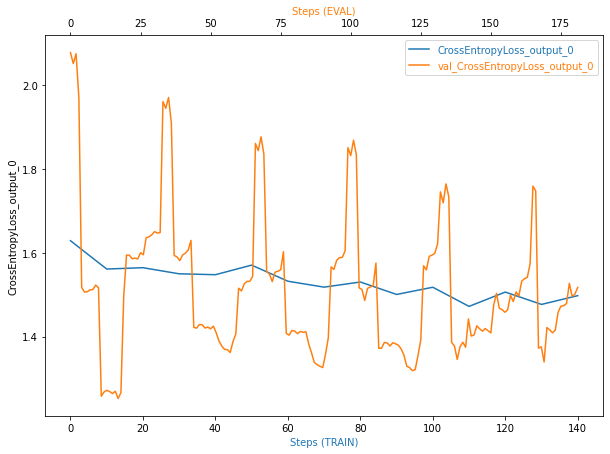

In [30]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

def plot_tensor(trial, tensor_name, directory, filename):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)
    
    fig.savefig(os.path.join(directory, filename + ".svg"), format = 'svg', dpi=300, bbox_inches='tight')

    plt.show()

plot_tensor(trial, tensor_name, report_image_dir, "tensor")

In [32]:
# Display the profiler output
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"

In [33]:
! aws s3 ls {rule_output_path} --recursive

2022-02-19 21:08:25     361642 smdebugger-inventory-hpo-2022-02-19-20-53-21-140/rule-output/ProfilerReport/profiler-output/profiler-report.html
2022-02-19 21:08:24     208555 smdebugger-inventory-hpo-2022-02-19-20-53-21-140/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2022-02-19 21:08:21        192 smdebugger-inventory-hpo-2022-02-19-20-53-21-140/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2022-02-19 21:08:21      27342 smdebugger-inventory-hpo-2022-02-19-20-53-21-140/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2022-02-19 21:08:21        126 smdebugger-inventory-hpo-2022-02-19-20-53-21-140/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2022-02-19 21:08:21        329 smdebugger-inventory-hpo-2022-02-19-20-53-21-140/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2022-02-19 21:08:21       6575 smdebugger-inventory-hpo-2022-02-19-20-53-21-14

In [34]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-679446279560/smdebugger-inventory-hpo-2022-02-19-20-53-21-140/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json to ProfilerReport/profiler-output/profiler-reports/Dataloader.json
download: s3://sagemaker-us-east-1-679446279560/smdebugger-inventory-hpo-2022-02-19-20-53-21-140/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-east-1-679446279560/smdebugger-inventory-hpo-2022-02-19-20-53-21-140/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-us-east-1-679446279560/smdebugger-inventory-hpo-2022-02-19-20-53-21-140/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb to ProfilerReport/profiler-output/profiler-report.ipynb
download: s3://sagemaker-us-east-1-6794462

In [35]:
# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]
profiler_report_name

'ProfilerReport'

In [36]:
IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

In [37]:
# Deploy your model to an endpoint
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()

class ImagePredictor(sagemaker.predictor.Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer
        )

pytorch_model = PyTorchModel(
    model_data=model_data_path, 
    role=role,
    entry_point='./inference.py',
    py_version='py3',
    framework_version='1.4.0',
    predictor_cls=ImagePredictor
)

predictor = pytorch_model.deploy(initial_instance_count=1, instance_type="ml.m5.large")

-----!

## Prediction

In [50]:
image_number = 524
request_dict={ "url": f"https://aft-vbi-pds.s3.amazonaws.com/bin-images/{image_number}.jpg" }
metadata = requests.get(f"https://aft-vbi-pds.s3.amazonaws.com/metadata/{image_number}.json").content
expected_quantity = json.loads(metadata)["EXPECTED_QUANTITY"]    

In [52]:
# Jpg request
img_bytes = requests.get(request_dict['url']).content
response_jpg = predictor.predict(img_bytes, initial_args={"ContentType": "image/jpeg"})

print(f"Expected number of items: {expected_quantity} ({request_dict['url']})")
print("Predicted number of items: " + classes[np.argmax(response_jpg, 1)[0]])

Expected number of items: 2 (https://aft-vbi-pds.s3.amazonaws.com/bin-images/524.jpg)
Predicted number of items: 2


In [56]:
response_json=predictor.predict(json.dumps(request_dict), initial_args={"ContentType": "application/json"})

print(f"Expected number of items: {expected_quantity} ({request_dict['url']})")
print("Predicted number of items: " + classes[np.argmax(response_jpg, 1)[0]])

Expected number of items: 2 (https://aft-vbi-pds.s3.amazonaws.com/bin-images/524.jpg)
Predicted number of items: 2


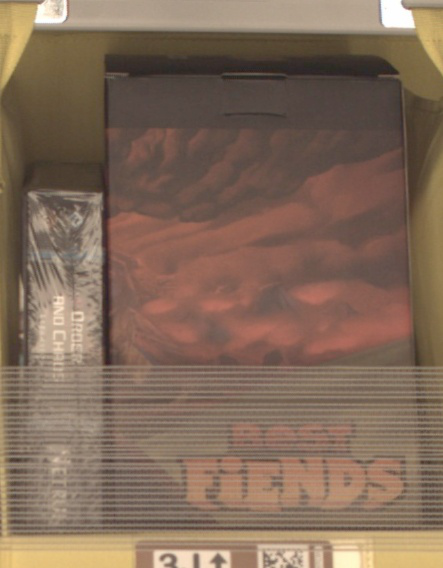

In [57]:
# Show image
Image.open(io.BytesIO(img_bytes))

In [ ]:
# Delete endpoint once work is done
predictor.delete_endpoint()

# Deploying model with more epochs

In [61]:
hyperparameters_more_epochs = best_hyperparameters.copy()
hyperparameters_more_epochs["epochs"] = 30

In [62]:
# Create training estimator
estimator_more_epochs = PyTorch(
    base_job_name="smdebugger-inventory-hpo",
    role=role,
    instance_count=1,
    instance_type="ml.g4dn.xlarge", #"ml.p3.2xlarge"
    entry_point="train.py",
    framework_version="1.4.0",
    py_version="py3",
    hyperparameters=hyperparameters_more_epochs,
    # debugger and profiler
    profiler_config=profiler_config,
    debugger_hook_config=debugger_config,
    rules=rules,
)

In [63]:
#Fit estimator
estimator_more_epochs.fit(inputs)

2022-02-19 22:12:02 Starting - Starting the training job...
2022-02-19 22:12:05 Starting - Launching requested ML instancesLossNotDecreasing: InProgress
VanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
......
2022-02-19 22:13:32 Starting - Preparing the instances for training.........
2022-02-19 22:14:54 Downloading - Downloading input data.........
2022-02-19 22:16:35 Training - Downloading the training image..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-02-19 22:16:46,696 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2022-02-19 22:16:46,719 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-02-19 22:16:48,138 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-02-19 22:16:48,524 sagema

In [64]:
model_data_path_more_epochs = estimator_more_epochs.model_data
print("Model saved at " + model_data_path_more_epochs)
debugger_artifacts_path_more_epochs = estimator_more_epochs.latest_job_debugger_artifacts_path()
print("Debugger artifacts saved at " + debugger_artifacts_path_more_epochs)
trial_more_epochs = create_trial(estimator_more_epochs.latest_job_debugger_artifacts_path())
print(estimator_more_epochs.latest_training_job.name)
tensor_name_more_epochs = trial_more_epochs.tensor_names()[0]
print("Ternsor name: " + tensor_name_more_epochs)
print("Number of points for TRAIN: " + str(len(trial_more_epochs.tensor(tensor_name).steps(mode=ModeKeys.TRAIN))))
print("Number of points for EVAL: " + str(len(trial_more_epochs.tensor(tensor_name).steps(mode=ModeKeys.EVAL))))

Model saved at s3://sagemaker-us-east-1-679446279560/smdebugger-inventory-hpo-2022-02-19-22-12-02-250/output/model.tar.gz
Debugger artifacts saved at s3://sagemaker-us-east-1-679446279560/smdebugger-inventory-hpo-2022-02-19-22-12-02-250/debug-output
[2022-02-19 22:55:19.888 ip-172-16-115-244:31871 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-679446279560/smdebugger-inventory-hpo-2022-02-19-22-12-02-250/debug-output
[2022-02-19 22:55:20.399 ip-172-16-115-244:31871 WARNING s3handler.py:183] Encountered the exception An error occurred while reading from response stream: ('Connection broken: IncompleteRead(0 bytes read, 4797 more expected)', IncompleteRead(0 bytes read, 4797 more expected)) while reading s3://sagemaker-us-east-1-679446279560/smdebugger-inventory-hpo-2022-02-19-22-12-02-250/debug-output/index/000000000/000000000103_worker_0.json . Will retry now
smdebugger-inventory-hpo-2022-02-19-22-12-02-250
[2022-02-19 22:55:30.847 ip-172-16-115-244:31

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


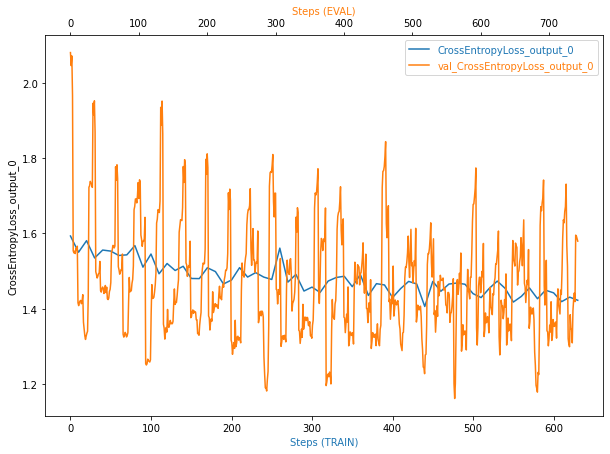

In [66]:
plot_tensor(trial_more_epochs, tensor_name_more_epochs, report_image_dir, "tensor_more_epochs")